## Part 0: Libraries and Set Up Jargon (The usual wall of imports)

# CIS 5450 Homework 2: SQL
## Due: Tuesday, February 21 2023, 10pm EST 
### Worth 100 points in total

Welcome to Homework 2! By now, you should be familiar with the world of data science and the Pandas library. This assignment focuses on helping you get to grips with a new tool: SQL.

Through this homework, we will be working with SQL (specifically **pandasql**) by exploring a [Indego](https://www.rideindego.com/) dataset containing bike rides, stations and weather data. We will also conduct some text analysis of reataurant reviews in Philly.

 <!-- We will finish off the homework with some text analysis. -->

We are introducing a lot of new things in this homework, and this is often where students start to get lost. Thus, we **strongly** encourage you to review the slides/material as you work through this assignment. 

**Before you begin:**
- Be sure to click "Copy to Drive" to make sure you're working on your own personal version of the homework
- Check the pinned FAQ post on Ed for updates! If you have been stuck, chances are other students have also faced similar problems.

# <ins> Note</ins>: this has historically been the _**MOST  difficult**_ HW out of all of them, so please watch the SQL recitation and **start early**!

In [1]:
!pip3 install penngrader
!pip install sqlalchemy==1.4.46
!pip install pandasql
!pip install geopy
!pip install -U kaleido

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26787 sha256=fc98967e6f73f1437ca23793296db07f868aa5405aca7e15b410dd203dd68f40
  Stored in directory: /root/.cache/pip/wheels/ed/8f/46/a383923333728744f01ba24adbd8e364f2cb9470a8b8e5b9ff
Successfully built pandasql
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 9.3 MB/s eta 0:00:00


In [2]:
from penngrader.grader import *
import pandas as pd
import datetime as dt
import geopy.distance as gp
import matplotlib.image as mpimg
import plotly.express as px
# import re
import pandasql as ps #SQL on Pandas Dataframe
import nltk
nltk.download('punkt')

from wordcloud import WordCloud

import matplotlib.pyplot as plt 
# from collections import Counter
# import random

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
# Three datasets we're using
! wget -nc https://storage.googleapis.com/penn-cis5450/indego_trips.csv
! wget -nc https://storage.googleapis.com/penn-cis5450/indego_stations.csv
! wget -nc https://storage.googleapis.com/penn-cis5450/weather_2022_PHL.csv
! wget -nc https://storage.googleapis.com/penn-cis5450/restaurant_reviews.csv

--2023-02-22 23:12:20--  https://storage.googleapis.com/penn-cis5450/indego_trips.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.196.128, 173.194.213.128, 173.194.217.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.196.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2033339 (1.9M) [text/csv]
Saving to: ‘indego_trips.csv’

indego_trips.csv    100%[===================>]   1.94M  --.-KB/s    in 0.03s   

2023-02-22 23:12:20 (59.4 MB/s) - ‘indego_trips.csv’ saved [2033339/2033339]

--2023-02-22 23:12:20--  https://storage.googleapis.com/penn-cis5450/indego_stations.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.196.128, 173.194.213.128, 173.194.217.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.196.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9052 (8.8K) [text/csv]
Saving to: ‘indego_stations.csv’

indego_stations.csv 

In [4]:
print(pd.__version__ )

1.3.5


### PennGrader Setup

In [5]:
# ENSURE YOUR PENN-ID IS ENTERED CORRECTLY. IF NOT, THE AUTOGRADER WON'T KNOW 
# TO ASSIGN POINTS TO YOU IN OUR BACKEND

STUDENT_ID = 51747601                                                           # YOUR PENN-ID GOES HERE AS AN INTEGER #


################################################################################
# Check (no need to modify below - we're checking if you changed the ID above)
if STUDENT_ID == 12345678:
   print("Hold up!!! \nHold up!!!!! \nHold up!!!!!!!! \n \nWe can't store your grade if you forgot to change the ID!")

In [6]:
grader = PennGrader(homework_id = 'CIS5450_23Sp_HW2', student_id = STUDENT_ID)

PennGrader initialized with Student ID: 51747601

Make sure this correct or we will not be able to store your grade




# Biking in Philadelphia

<br>
<center><img src = "https://whyy.org/wp-content/uploads/2021/11/AP-indego-bike-share-philly-docking-station-110421-768x512.jpg" width= "500" align ="center"/></center>
<br>

I'm sure in your time in Philadelphia so far you've come across these blue bikes and stations. Indego is the company responsible for this bike sharing ride system, and they make data on bike trips available to the public. This data can not only be useful to get information of how people in Philly use bikes, but it can give information on the most visited places in the city which can be useful for city planners and business owners.


In this homework, we'll be exploring some data about bikes including:

*   Trips: data about bike trips during the first week of October 2022.

*   Stations: data about bike stations, their ID and Name.

*   Weather: data about the weather in Philadelphia during 2022.


We'll be parsing this data into dataframes and relations, and then exploring how to query and assemble the tables into results. We will primarily be using PandaSQL, but for some of the initial questions, we will ask you to perform the same operations in Pandas as well, so as to familiarize you with the differences and similarities of the two.

For the final part of this Homework, we'll use a fourth database with restaurants and reviews, and perform some text analysis.

## Part 1: Load & Process our Datasets [10 points total]

Before we get into the data, we first need to load and clean our datasets. 

# Metadata
You'll be working with four CSV files:
- `indego_trips.csv`: contains data about each trip, like the origin station, destination station and duration. 
- `indego_stations.csv`: includes information about stations and their status in January 2023.
- `weather_2022_PHL.csv`: has one row per day during 2022 and shows weather information.
- `restaurant_reviews.csv`: has several reviews about three restaurants.

**TO-DO**:
* Load `indego_trips.csv` and save the data to a dataframe called `trips_df`.
* Load `indego_stations.csv` and save the data to a dataframe called `stations_df`.
* Load `weather_2022_PHL.csv` and save the data to a dataframe called `weather_df`.
* Load `restaurant_reviews.csv` and save the data to a dataframe called `reviews_df`.

In [7]:
# TODO: Import the 4 datasets to pandas dataframes -- make sure the dataframes are named correctly! 
trips_df = pd.read_csv("indego_trips.csv")
stations_df = pd.read_csv("indego_stations.csv")
weather_df = pd.read_csv("weather_2022_PHL.csv")
reviews_df = pd.read_csv("restaurant_reviews.csv")

In [8]:
# TODO: view `trips_df` (just the first 5 rows with .head() is fine) to make sure the import was successful
trips_df.head(5)

,trip_id,duration,start_time,end_time,start_station,start_lat,start_lon,end_station,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type,bike_type
0,536547052,9,10/1/2022 0:00,10/1/2022 0:09,3190.0,39.948921,-75.169907,3158.0,39.925522,-75.169037,23553,30.0,One Way,Indego30,electric
1,536547050,19,10/1/2022 0:01,10/1/2022 0:20,3168.0,39.951340,-75.173943,3034.0,39.933151,-75.162483,22190,30.0,One Way,Indego30,electric
2,536547048,12,10/1/2022 0:02,10/1/2022 0:14,3190.0,39.948921,-75.169907,3158.0,39.925522,-75.169037,18789,30.0,One Way,Indego30,electric
3,536547046,5,10/1/2022 0:03,10/1/2022 0:08,3075.0,39.967178,-75.161247,3039.0,39.971569,-75.159927,23383,30.0,One Way,Indego30,electric
4,536547044,11,10/1/2022 0:03,10/1/2022 0:14,3050.0,39.953388,-75.154259,3075.0,39.967178,-75.161247,5367,30.0,One Way,Indego30,standard


In [9]:
# TODO: view `stations_df` (just the first 5 rows with .head() is fine)to make sure the import was successful
stations_df.head(5)

,station_id,station_name,day_of_go_live_date,status,zone
0,3000,Virtual Station,4/23/2015,Active,0
1,3004,Municipal Services Building Plaza,4/23/2015,Active,0
2,3005,"Welcome Park, NPS",4/23/2015,Active,0
3,3006,40th & Spruce,4/23/2015,Active,2
4,3007,"11th & Pine, Kahn Park",4/23/2015,Active,0


In [10]:
# TODO: view `weather_df` (just the first 5 rows with .head() is fine)to make sure the import was successful
weather_df.head(5)

,date,actual_mean_temp,actual_min_temp,actual_max_temp,average_min_temp,average_max_temp,record_min_temp,record_max_temp,record_min_temp_year,record_max_temp_year,actual_precipitation,average_precipitation,record_precipitation
0,1/1/2022,35,28,42,27,41,4,64,1881,2005,0.00,0.09,1.60
1,1/2/2022,37,29,44,26,41,7,67,1968,1876,0.00,0.10,1.68
2,1/3/2022,36,28,44,26,41,-3,63,1879,2000,0.72,0.09,1.50
3,1/4/2022,50,42,58,26,41,2,68,1918,1950,0.37,0.10,1.51
4,1/5/2022,37,24,50,26,40,-2,66,1904,1997,0.00,0.10,2.24


In [11]:
# TODO: view `reviews_df` (just the first 5 rows with .head() is fine)to make sure the import was successful
reviews_df.head(5)

,restaurant,review,zone
0,Gloria Restaurant,Today is the third time I've come to Gloria Re...,1
1,Gloria Restaurant,I have been to Gloria Restaurant a couple time...,1
2,Gloria Restaurant,Last Saturday I went to this restaurant hoping...,1
3,Gloria Restaurant,"First off, let me say I have never been to the...",1
4,Gloria Restaurant,I've been coming here for a while now and I wa...,1


### 1.1 Data Preprocessing

Next, we are going to want to clean up our dataframes, namely `trips_df` and `stations_df`, by 

1.   Fixing columns
2.   Changing datatypes
3.   Handling nulls


First, let us view the first few rows of `trips_df`. You may also call `.info()` and additionally check the cardinality of each column to view the specifics of the dataframe. This is a good first step to take for Exploratory Data Analysis (EDA).

In [12]:
# view the .info() information for trips_df
trips_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15502 entries, 0 to 15501
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   trip_id              15502 non-null  int64  
 1   duration             15502 non-null  int64  
 2   start_time           15502 non-null  object 
 3   end_time             15502 non-null  object 
 4   start_station        15477 non-null  float64
 5   start_lat            15477 non-null  float64
 6   start_lon            15477 non-null  float64
 7   end_station          15477 non-null  float64
 8   end_lat              15255 non-null  float64
 9   end_lon              15255 non-null  float64
 10  bike_id              15477 non-null  object 
 11  plan_duration        15477 non-null  float64
 12  trip_route_category  15477 non-null  object 
 13  passholder_type      15477 non-null  object 
 14  bike_type            15477 non-null  object 
dtypes: float64(7), int64(2), object(6)
m

In [13]:
stations_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203 entries, 0 to 202
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   station_id           203 non-null    int64 
 1   station_name         203 non-null    object
 2   day_of_go_live_date  203 non-null    object
 3   status               203 non-null    object
 4   zone                 203 non-null    int64 
dtypes: int64(2), object(3)
memory usage: 8.1+ KB


#### 1.1.1 Cleaning `trips_df` (4 points)

`.info()` gives us meaningful information regarding columns, their types, and the amount of nulls, based on which we can now clean our dataframe. 

Perform these steps and save results on a new dataframe: `trips_cleaned_df` 

**TODO**:
* Drop the column `plan_duration`. We already have that information in the column `passholder_type`, which is more understandable.
* Drop the rows where `end_station` is 3000. This is a virtual station used for maintainance, and doesn't represent a real trip.
* Drop all rows with null values.
* Cast the columns:
  -  `start_time`, `end_time`, `trip_route_category`, `passholder_type`, `bike_type` as **string**. (Cast to 'string' and not 'str') 
  - `bike_id` as **int**.
* Save results as `trips_cleaned_df` and sort it by `trip_id` ascending

After performing these steps, `trips_cleaned_df` should have the following schema:

**Final Schema**:
>trip_id | duration | start_time | end_time | start_station | start_lat | start_lon | end_station |  end_lat | end_lon |  bike_id | trip_route_category | passholder_type | bike_type
>--- | --- | --- |--- | --- | --- | --- |--- | --- | --- |--- |--- | --- | --- |

In [14]:
# TO-DO: drop the plan_duration column
trips_cleaned_df = trips_df.drop(["plan_duration"], axis=1)

In [15]:
# TO-DO: drop rows with end_station = 3000
trips_cleaned_df = trips_cleaned_df[trips_cleaned_df.end_station != 3000]

In [16]:
# TO-DO: drop nulls
trips_cleaned_df = trips_cleaned_df.dropna()

In [17]:
# TO-DO: cast columns as indicated types
trips_cleaned_df["start_time"] = trips_cleaned_df["start_time"].astype("string")
trips_cleaned_df['end_time'] = trips_cleaned_df['end_time'].astype("string")
trips_cleaned_df['trip_route_category'] = trips_cleaned_df['trip_route_category'].astype("string")
trips_cleaned_df['passholder_type'] = trips_cleaned_df['passholder_type'].astype("string")
trips_cleaned_df['bike_type'] = trips_cleaned_df['bike_type'].astype("string")
trips_cleaned_df['bike_id'] = trips_cleaned_df['bike_id'].astype(int)

In [18]:
#TO-DO: save changes to trips_cleaned_df that is sorted by 'trip_id' 
trips_cleaned_df = trips_cleaned_df.sort_values(["trip_id"])

In [19]:
# 4 points
grader.grade(test_case_id = 'test_cleaning_trips', answer = [len(trips_cleaned_df), trips_cleaned_df.head()])

Correct! You earned 4/4 points. You are a star!

Your submission has been successfully recorded in the gradebook.


#### 1.1.2 Processing Stations (3 points)

`stations_df` contains information on Indego stations across the city. We will clean this df by removing Inactive stations and stations created after October 2022.

Perform these steps and assign the cleaned dataframe to `stations_cleaned_df`.

**TODO**:
* **Cast** column `day_of_go_live_date` as datetime64[ns].
* **Drop** the stations that were created **after 10/7/2022** (i.e. we want to keep the ones on or before 10/7/2022)
* **Drop** the stations that have an **Inactive** status.
* **Drop** the columns `day_of_go_live_date` and `status`
* **Create** a new column called `is_west_philly` that is True if zone is 2 or 3 and False otherwise.
* **Save** the resulting dataframe as `stations_cleaned_df`, and sort it by `station_id` ascending


After performing these steps, `stations_cleaned_df` should have the following schema:

**Final Schema**:
>station_id | station_name | zone | is_west_philly
>--- | --- | --- |--- |

In [20]:
from numpy import datetime64
# TO-DO: Your code goes below. We recommend creating code comments for each of the bullets above (like we did for you in 1.1.1)
stations_cleaned_df = stations_df.copy()
stations_cleaned_df["day_of_go_live_date"] = stations_cleaned_df["day_of_go_live_date"].astype(datetime64)
stations_cleaned_df = stations_cleaned_df[stations_cleaned_df["day_of_go_live_date"] <= "10/7/2022"]
stations_cleaned_df = stations_cleaned_df[stations_cleaned_df.status != "Inactive"]
stations_cleaned_df = stations_cleaned_df.drop(["day_of_go_live_date", "status"], axis=1)
stations_cleaned_df["is_west_philly"] = stations_cleaned_df.apply(lambda x: True if x.zone == 2 else False, axis=1)
stations_cleaned_df = stations_cleaned_df.sort_values(["station_id"])

In [21]:
# 3 points
grader.grade(test_case_id = 'test_stations_processing', answer = (len(stations_cleaned_df), stations_cleaned_df.head()))

Correct! You earned 3/3 points. You are a star!

Your submission has been successfully recorded in the gradebook.


#### 1.1.3 Cleaning the weather (3 points)
Then, let's clean `weather_df` and make it usable.

In [22]:
# view .info() of weather_df to sense check it
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   365 non-null    object 
 1   actual_mean_temp       365 non-null    int64  
 2   actual_min_temp        365 non-null    int64  
 3   actual_max_temp        365 non-null    int64  
 4   average_min_temp       365 non-null    int64  
 5   average_max_temp       365 non-null    int64  
 6   record_min_temp        365 non-null    int64  
 7   record_max_temp        365 non-null    int64  
 8   record_min_temp_year   365 non-null    int64  
 9   record_max_temp_year   365 non-null    int64  
 10  actual_precipitation   365 non-null    float64
 11  average_precipitation  365 non-null    float64
 12  record_precipitation   365 non-null    float64
dtypes: float64(3), int64(9), object(1)
memory usage: 37.2+ KB



**TO-DO**:
* Create `weather_cleaned_df` and only keep the following 5 columns:
     * `date`, `actual_mean_temp`, `actual_min_temp`, `actual_max_temp`, `actual_precipitation`
* Convert column `date` into type `datetime64[ns]`.
* Keep only the rows from 9/1/2022 to 10/31/2022, inclusive.
* Sort by column `date` descending.

After performing these steps, `weather_cleaned_df` should have the following schema:

**Final Schema**:
>date | actual_mean_temp | actual_min_temp | actual_max_temp | actual_precipitation
>--- | --- | --- |--- |--- |

In [23]:
#TO-DO: clean up the weather_df 

weather_cleaned_df = weather_df[["date", "actual_mean_temp","actual_min_temp","actual_max_temp","actual_precipitation"]]
weather_cleaned_df["date"] = weather_cleaned_df["date"].astype(datetime64)
weather_cleaned_df = weather_cleaned_df["9/1/2022" <= weather_cleaned_df["date"]]
weather_cleaned_df = weather_cleaned_df[weather_cleaned_df["date"] <= "10/31/2022"]
weather_cleaned_df = weather_cleaned_df.sort_values(["date"], ascending=False)

<ipython-input-23-6e62e25b11ac>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_cleaned_df["date"] = weather_cleaned_df["date"].astype(datetime64)


In [24]:
# 3 points
grader.grade(test_case_id = 'test_cleaning_weather', answer = [len(weather_cleaned_df),weather_cleaned_df.head()])

Correct! You earned 3/3 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### 1.2 Your Sandbox 

`.info()` is just one of many basic tools that you can use for Exploratory Data Analysis (EDA). Instead of throwing you straight into the deep end, we wanted to give you a chance to take some time and explore the data on your own. **This section is not graded**, so for the speedrunners out there feel free to just jump in, but we wanted to at least give you a small space to utilize your EDA toolkit to familiarize yourself with all the data you just downloaded.

Some suggestions to get you started:
- `df.head()`
- `df.describe()`
- `Series.unique()`

In [25]:
# Your EDA here! Feel free to add more cells
trips_cleaned_df.head()

,trip_id,duration,start_time,end_time,start_station,start_lat,start_lon,end_station,end_lat,end_lon,bike_id,trip_route_category,passholder_type,bike_type
68,536546924,3,10/1/2022 1:50,10/1/2022 1:53,3188.0,39.904709,-75.173401,3188.0,39.904709,-75.173401,11708,Round Trip,Indego30,standard
67,536546925,3,10/1/2022 1:50,10/1/2022 1:53,3188.0,39.904709,-75.173401,3188.0,39.904709,-75.173401,3483,Round Trip,Indego30,standard
66,536546927,7,10/1/2022 1:48,10/1/2022 1:55,3010.0,39.947109,-75.166183,3064.0,39.938400,-75.173271,14655,One Way,Indego30,standard
65,536546929,7,10/1/2022 1:48,10/1/2022 1:55,3010.0,39.947109,-75.166183,3064.0,39.938400,-75.173271,12987,One Way,Indego30,standard
63,536546932,6,10/1/2022 1:41,10/1/2022 1:47,3004.0,39.953781,-75.163742,3206.0,39.951740,-75.170631,22554,One Way,Day Pass,electric


## Part 2: Exploring the Data with PandasSQL (and Pandas) [73 points total]

Now that you are familiar (or still unfamiliar) with the dataset, we will now introduce you to SQL, or more specifically **pandasql**: a package created to allow users to query pandas DataFrames with SQL statements.

## 👇👇👇 IMPORTANT: Pay VERY CLOSE attention to this style guide! 👇👇👇

The typical flow to use pandasql (aliased as `ps`) is as follows:
1. Write a SQL query in the form of a string
    - **String Syntax:** use triple quotes `"""<your query>"""` to write multi-line strings in Python
    - **Aliases are your friend:** if there are very long table names or you find yourself needed to declare the source (common during join tasks), it's almost always optimal to alias your tables with short INTUITIVE alias names
    - **New Clauses New Line:** each of the main SQL clauses (`SELECT`, `FROM`, `WHERE`, etc.) should begin on a new line
    - **Use Indentation:** if there are many components for a single clause, separate them out with new <ins>indented</ins> lines.

    Example below:
    ```SQL
    """
    SELECT ltn.some_id, SUM(stn.some_value) AS total
    FROM long_table_name AS ltn
         INNER JOIN short_table_name AS stn 
            ON ltn.common_key = stn.common_key
         INNER JOIN med_table_name AS mtn
            ON ltn.other_key = mtn.other_key
    WHERE ltn.col1 > value
         AND stn.col2 <= another_value
         AND mtn.col3 != something_else
    GROUP BY ltn.some_id
    ORDER BY total DESC
    """
    ```
2. Run the query using `ps.sqldf(your_query, locals())`

Pandasql is convenient in that it allows you to reference the dataframes that are currently defined in your notebook, so you will be able to fully utilize the dataframes `trips_cleaned_df`, `stations_cleaned_df` and `weather__cleaned_df` that you have created above!

Given that it is a brand new language, we wanted to give you a chance to directly compare the similarities/differences of the pandas that you already know and the SQL that you are about to learn. Thus, for each of the simpler queries, we may ask that you **look into the question twice: once with pandas and once with pandasql**. 

### 2.1 One Way vs Round Trip [19 points]

#### 2.1.1 How many of the rides taken were Round Trip journeys? (4 points)

The dataframe `trips_cleaned_df` contains information for each ride. We want to know which of these rides were Round Trip journeys, and how many such rides were taken.

**TO-DO:**

*    Using what you learned in EDA in 1.2, use `pandas` to filter on the appropriate column to obtain only round trips, and save it to a DataFrame called `round_df`, which is sorted by `trip_id` in ascending order.
*   Save the number of rides in the integer variable `number_of_rounds`. 

In [26]:
# TO-DO: Use pandas to obtain rides that were round trip
round_df = trips_cleaned_df[trips_cleaned_df["trip_route_category"] == "Round Trip"]
round_df = round_df.sort_values(["trip_id"])

In [27]:
# TO-DO : Save the number of round trip rides obtained from round_df to number_of_rounds
number_of_rounds = len(round_df)
number_of_rounds

930

In [28]:
# 2 points
grader.grade(test_case_id = 'test_round', answer = (round_df, number_of_rounds))

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


**TO-DO:** Now using **pandasql**, calculate the number of round trips in trips_cleaned_df and save it to the dataframe `round_df_sql`, with the column named `num`. This will be a rather unconventional 1x1 dataframe, but that's OK.

**Final Schema:**

> num|
> --- |

In [29]:
# TODO: Use pandasql to calculate the number of round trips
round_query = """
              SELECT COUNT(*) AS num
              FROM trips_cleaned_df AS trips
              WHERE trips.trip_route_category == "Round Trip"
              """
round_df_sql = ps.sqldf(round_query, locals())
round_df_sql

,num
0,930


In [30]:
# 2 points
grader.grade(test_case_id = 'test_round_sql', answer = round_df_sql)

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


#### 2.1.2 What was the duration of these round trips? [4 points]

The dataframe `round_df` contains information for each ride that was a round trip. We want to know the average duration of the trip for all these rides. 

**TO-DO:** Using **pandas**, calculate the average duration of the rides in `round_df` and save it to the variable `avg_round_pd`. Please make sure you do NOT cast it to any type explicitly nor should you round it. 





In [31]:
# TODO: Use pandas to calculate the average duration of round trips
avg_round_pd = round_df.duration.mean()

In [32]:
# 2 points
grader.grade(test_case_id = 'test_round_dur_pd', answer = avg_round_pd)

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


**TO-DO:** Using **pandasql**, calculate the average duration of the rides in round_df and save it to the dataframe `avg_round_df`, with the column named `avg_dur`. Please make sure you do NOT cast it to any type explicitly nor should you round it.

Again, this will be a 1x1 dataframe but that's OK.

**Final Schema:**


> avg_dur |
> --- |

In [33]:
# TODO: Use pandasql to calculate the average duration of round trips
avg_dur_query = """
                SELECT AVG(duration) AS avg_dur
                FROM round_df
                """

avg_round_df = ps.sqldf(avg_dur_query, locals())
avg_round_df

,avg_dur
0,20.107527


In [34]:
# 2 points
grader.grade(test_case_id = 'test_round_dur', answer = avg_round_df)

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


#### 2.1.3 How long do you take? (5 points)

Some of the rides listed in the `trips_cleaned_df` are marked as Day Pass. We'd like to know how long riders take their bikes out when they get a Day Pass. 

**TO-DO:** Using **pandas**, and what you learned in EDA in 1.2, use a filter on the appropriate column to obtain only “Day Pass” to calculate the average duration of these trips from `trips_cleaned_df` and save it to the variable `day_df_pd`. Please make sure you do not cast it to any type explicitly, or round it.  

**Final Schema:**

> avg_dur |
> --- |

Please use only `trips_cleaned_df` for both `pandas` and `pandasql`.

In [35]:
# TODO: Use pandas to calculate the average duration of trips with a day pass 
day_df_pd = trips_cleaned_df[trips_cleaned_df.passholder_type == "Day Pass"].duration.mean()

**TO-DO:** Repeat the same using **pandasql** and save it as `day_df_sql` where the average duration column should be named `avg_dur`.

In [36]:
# TODO: Use pandasql to calculate the average duration of trips with a day pass 
day_query = """
            SELECT AVG(duration) AS avg_dur
            FROM trips_cleaned_df
            WHERE passholder_type == "Day Pass"
            """

day_df_sql = ps.sqldf(day_query, locals())
day_df_sql

,avg_dur
0,31.43299


In [37]:
# 4 points
grader.grade(test_case_id = 'test_day_dur', answer = (day_df_sql, day_df_pd, day_query))

Correct! You earned 4/4 points. You are a star!

Your submission has been successfully recorded in the gradebook.


##### **Reflect:**  What do you think? (1 point)

Is there a difference between the average duration for round trips (2.1.2) and Day Pass journeys (2.1.3)? Please state your answer as Yes/No with a reason for the possible similarity/difference? [1 pt]



In [38]:
your_ans = """Yes, the former one is in category: round trip, the latter is in pass holder type: Day Pass, their calculations are based on different statistics"""

In [39]:
# Grader Cell for Text Response (do not modify) [1 point]
grader.grade(test_case_id = 'test_q', answer = your_ans)

Correct! You earned 1/1 points. You are a star!

Your submission has been successfully recorded in the gradebook.


#### 2.1.4 Ratio of Rides (6 points)

Some of the rides listed in the `trips_cleaned_df` are marked as One Way while some are marked as Round Trip. We'd like to know the ratio between the number of one - way trips to the number of round-trip journeys. 

**TO-DO:** Using **pandas**, calculate the ratio of the number of one-way rides to the number of round-trip rides from `trips_cleaned_df` and save it to the variable `ratio_1_round` 

**HINT:** Let the answer remain a float value when using pandas. 

In [40]:
# TO-DO: Use pandas to obtain the ratio of average number of one-way trips to average number of round-trip journeys
ratio_1_round = len(trips_cleaned_df[trips_cleaned_df.trip_route_category == "One Way"]) / len(trips_cleaned_df[trips_cleaned_df.trip_route_category == "Round Trip"])
print(len(trips_cleaned_df[trips_cleaned_df.trip_route_category == "One Way"]), len(trips_cleaned_df[trips_cleaned_df.trip_route_category == "Round Trip"]), 14325/930)

14325 930 15.403225806451612


In [41]:
# 2 points
grader.grade(test_case_id = 'test_ratio_pd', answer = ratio_1_round)

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


Now, let's try doing the same thing using pandasql, and see if the results match. 

**TODO:** Using **pandasql**, calculate the ratio of the number of one-way rides to the number of round-trip rides from `trips_cleaned_df` and save it to the dataframe `ratio_df`, naming the column `'ratio'`. 

Try to make use of subqueries here! Note, your results should be equivalent (to each other, and the answer, of course) if you have done both parts correctly.

**HINT:** Cast your ratio to `float` type.  

**Final Schema:**

> ratio |
> --- |

In [42]:
# TODO: Use pandasql to obtain the ratio of number of one-way trips to  number of round trips 

ratio_query = """  
              SELECT (CAST(COUNT(*) AS FLOAT) / (round_num + 0.0)) AS ratio
              FROM trips_cleaned_df, (
                SELECT COUNT(*) AS round_num
                FROM trips_cleaned_df
                WHERE trip_route_category == "Round Trip"
              )
              WHERE trip_route_category == "One Way"
              """

ratio_df = ps.sqldf(ratio_query, locals())
ratio_df

,ratio
0,15.403226


In [43]:
# 4 points
grader.grade(test_case_id = 'test_ratio_sql', answer = (ratio_df, ratio_query))

Correct! You earned 4/4 points. You are a star!

Your submission has been successfully recorded in the gradebook.


###2.2 Station Involvement [16 points]

#### 2.2.1 Names not numbers [5 points]
We will now use `stations_cleaned_df` to modify our `trips_final_df`. If you look at the rides data, you will notice that both start and end station columns have numbers corresponding to the station ID listed. Using the station ID listed in stations_df, we want to include station names instead of station IDs in our `trips_final_df`.

**TO-DO** (`pandas`): 
* Drop records with missing values and update `trips_cleaned_df`
* Create a new dataframe called `trips_final_df` which you'll use after this question. Begin by assigning a **copy** of `trips_cleaned_df` to it.
  * **Hint:** Don't just set them equal right away! Refer to the ```.copy()``` function!
. 
* Replace the IDs in the `'start_station'` column of `trips_final_df` with the corresponding station name. 
* Replace the IDs in the `'end_station'` column of `trips_final_df` with the corresponding station name. 
* If the any station ID cannot be mapped to a name, the name should be set to 'Unknown'
* Sort `trips_final_df` by the trip_id (in ascending order). 



In [44]:
# TO-DO : Drop missing values
trips_cleaned_df = trips_cleaned_df.dropna()

In [45]:
# TO-DO : Create a copy named trips_final_df using .copy()
trips_final_df = trips_cleaned_df.copy()

In [46]:
from numpy.lib.twodim_base import tri
# TO-DO: Replace station IDs with station names in trips_final_df. Read ALL the bullets above carefully!
merged_table = stations_cleaned_df[["station_id","station_name"]].merge(trips_final_df, how="right", left_on="station_id", right_on="start_station").drop(["start_station", "station_id"], axis=1)
merged_table = merged_table.rename(columns={"station_name": "start_station"})
merged_table = merged_table.merge(stations_cleaned_df[["station_id","station_name"]], how="left", left_on="end_station", right_on="station_id").drop(["end_station", "station_id"], axis=1)
merged_table = merged_table.rename(columns={"station_name": "end_station"})
merged_table.fillna('Unknown', inplace=True)

In [47]:
# TO-DO: Sort trips_final_df by the trip_id
trips_final_df = merged_table.sort_values("trip_id")
trips_final_df[trips_final_df["start_station"] == "Unknown"]
trips_final_df.iloc[80, :]

start_station                 Unknown
trip_id                     536574924
duration                           10
start_time             10/1/2022 2:48
end_time               10/1/2022 2:58
start_lat                    39.95134
start_lon                   -75.16758
end_lat                     39.955761
end_lon                    -75.189819
bike_id                         23133
trip_route_category           One Way
passholder_type              Indego30
bike_type                    electric
end_station             33rd & Market
Name: 80, dtype: object

In [48]:
# 2 points
grader.grade(test_case_id = 'test_stations', answer = trips_final_df)

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


**TO-DO** : Repeat the same using `trips_cleaned_df` (only for this sql query) and `pandasql`, saving it as `trips_stations_sql`.

<ins>Remember:</ins> If a station ID cannot be mapped to a name, the name should be **NULL**

In [49]:
#TODO : Use pandasql to replace station IDs with station names in trips_cleaned_df and save it as trips_stations_sql
# """
# SELECT ltn.some_id, SUM(stn.some_value) AS total
# FROM long_table_name AS ltn
#    INNER JOIN short_table_name AS stn 
#       ON ltn.common_key = stn.common_key
#    INNER JOIN med_table_name AS mtn
#       ON ltn.other_key = mtn.other_key
# WHERE ltn.col1 > value
#    AND stn.col2 <= another_value
#    AND mtn.col3 != something_else
# GROUP BY ltn.some_id
# ORDER BY total DESC
# """
replace_query = """
                SELECT trip_id, duration, start_time, end_time, start_lat, start_lon, end_lat, end_lon, bike_id, trip_route_category, passholder_type,	bike_type, s1.station_name AS start_station, s2.station_name AS end_station
                FROM trips_cleaned_df t
                  LEFT JOIN stations_cleaned_df s1
                    ON t.start_station = s1.station_id
                  LEFT JOIN stations_cleaned_df s2
                    ON t.end_station = s2.station_id
                """

trips_stations_sql = ps.sqldf(replace_query, locals())#ps.sqldf(replace_query, locals())
trips_stations_sql

,trip_id,duration,start_time,end_time,start_lat,start_lon,end_lat,end_lon,bike_id,trip_route_category,passholder_type,bike_type,start_station,end_station
0,536546924,3,10/1/2022 1:50,10/1/2022 1:53,39.904709,-75.173401,39.904709,-75.173401,11708,Round Trip,Indego30,standard,"Broad & Pattison, BSL","Broad & Pattison, BSL"
1,536546925,3,10/1/2022 1:50,10/1/2022 1:53,39.904709,-75.173401,39.904709,-75.173401,3483,Round Trip,Indego30,standard,"Broad & Pattison, BSL","Broad & Pattison, BSL"
2,536546927,7,10/1/2022 1:48,10/1/2022 1:55,39.947109,-75.166183,39.938400,-75.173271,14655,One Way,Indego30,standard,15th & Spruce,"18th & Washington, Chew Playground"
3,536546929,7,10/1/2022 1:48,10/1/2022 1:55,39.947109,-75.166183,39.938400,-75.173271,12987,One Way,Indego30,standard,15th & Spruce,"18th & Washington, Chew Playground"
4,536546932,6,10/1/2022 1:41,10/1/2022 1:47,39.953781,-75.163742,39.951740,-75.170631,22554,One Way,Day Pass,electric,Municipal Services Building Plaza,18th & Chestnut
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15250,540422839,100,10/7/2022 21:36,10/7/2022 23:16,39.947922,-75.162369,39.947922,-75.162369,22404,Round Trip,Day Pass,electric,13th & Locust,13th & Locust
15251,540422840,102,10/7/2022 21:35,10/7/2022 23:17,39.947922,-75.162369,39.947922,-75.162369,23321,Round Trip,Day Pass,electric,13th & Locust,13th & Locust
15252,540422841,102,10/7/2022 21:34,10/7/2022 23:16,39.947922,-75.162369,39.947922,-75.162369,22950,Round Trip,Day Pass,electric,13th & Locust,13th & Locust
15253,540422860,50,10/7/2022 21:27,10/7/2022 22:17,39.950249,-75.160278,39.971569,-75.159927,14533,One Way,Indego30,standard,12th & Chestnut,Broad & Girard


In [50]:
#3 points
grader.grade(test_case_id = 'test_stations_sql', answer = (trips_stations_sql, replace_query))

Correct! You earned 3/3 points. You are a star!

Your submission has been successfully recorded in the gradebook.


#### 2.2.2 Morning Class? (5 points)
We are all pretty familiar with University City, most of you probably live in or commute to this area every day. We want to count the number of people who start out at the University City Station before noon. 

**TO-DO**: 
* The first step involved is creating a new column in `trips_final_df` called `hour` where you will extract the hour of the `start_time` column. You can do this using pandas, and an apply function. 
* The next step is to use `pandasql` to count the number of rides that start at the 'University City Station' before noon (do not include trips with hour 12) and store the result in a dataframe called `ucity_df`, with the column name as `ride_count`.

**Hint**: you may find it helpful to look up the `.Timestamp()` function to understand how to extract the hour of a particular date. 

In [51]:
#TODO : Create a new column called hour
trips_final_df["hour"] = trips_final_df.start_time.apply(lambda x: x.split()[1].split(":")[0]).astype(int)

In [52]:
# Count the number of rides before noon that started at `University City Station`
ucity_query = """ 
              SELECT COUNT(*) AS ride_count
              FROM trips_final_df
              WHERE hour < 12 and start_station = "University City Station"
              """

ucity_df = ps.sqldf(ucity_query, locals())
ucity_df 

,ride_count
0,23


In [53]:
# 7 points
grader.grade(test_case_id = 'test_ucity', answer = (trips_final_df, ucity_df, ucity_query))

Correct! You earned 5/5 points. You are a star!

Your submission has been successfully recorded in the gradebook.


#### 2.2.3 Most Popular Stations (6 points)
We now want to see which stations from `trips_final_df` are used most frequently. 

**TODO**: 
* Find the total number of rides for each `start_station`
* Return the top 3 most frequently used stations in a dataframe named `top3_df` where the schema looks like this:

> Station | Count_rides
> --- | ---

**Hint**: Use `pandasql` to do this in ONE query. 

In [54]:
#TODO: Return the top three used stations by number of rides
top3_query = """ 
             SELECT start_station AS Station, COUNT(*) AS Count_rides
             FROM trips_final_df
             GROUP BY start_station
             ORDER BY Count_rides DESC
             LIMIT 3
             """
top3_df = ps.sqldf(top3_query, locals())
top3_df

,Station,Count_rides
0,17th & Locust,267
1,12th & Chestnut,238
2,15th & Spruce,233


In [55]:
# 6 points
grader.grade(test_case_id = 'test_freq_stat', answer = (top3_query,top3_df))

Correct! You earned 6/6 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### 2.3 Determining the Distance [8 points]

We are going to be using a new package called geopy to calculate the distance between the start and end stations for a particular ride. 

`geopy` has been imported as `gp` above, and the `.geodesic()` gives you the distance between two sets of coordinates. We have the coordinates for the start_station and end_station for each ride. 

**TO-DO**: 
* For the trip with `'trip_id': 540422637`, find the latitude and longitudes of both the start and end stations.
* Save the latitude and longitude as **tuples** into variables `coords_1` and `coords_2` for the `'start_station'` and `'end_station'` respectively.
  - Do **NOT** hard code the values: you will get a **ZERO** for the question when we manually review for this!
* Use geopy to calculate the distance **in miles** between the two stations and save it to the variable final_dist. 

In [56]:
# TO-DO: Use pandasql to obtain the latitude and longitude of the start and end stations for ride ID 540422637. 
latlng_query = """  
               SELECT start_lat, start_lon, end_lat, end_lon
               FROM trips_final_df
               WHERE trip_id = 540422637
               """

latlng_df = ps.sqldf(latlng_query, locals())
latlng_df

,start_lat,start_lon,end_lat,end_lon
0,39.947109,-75.166183,39.927769,-75.151031


In [57]:
# TO-DO : Fill in the coordinates using the dataframe that has the resultant coordinates
coords_1 = (latlng_df.loc[0, "start_lat"], latlng_df.loc[0, "start_lon"])
coords_2 = (latlng_df.loc[0, "end_lat"], latlng_df.loc[0, "end_lon"])
print(coords_1, coords_2)

(39.947109, -75.166183) (39.927769, -75.151031)


In [58]:
# TO-DO: Use geopy and its appropriate functions to calculate the distance between the two stations 
final_dist = gp.geodesic(coords_1, coords_2).miles
final_dist

1.5582014020414594

In [59]:
# 8 points
grader.grade(test_case_id = 'test_geodist', answer = (coords_1, coords_2, final_dist, latlng_query))

Correct! You earned 8/8 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### 2.4 Destinations from Amtrak Station [7 points]
As you might imagine, Amtrak Station is a very important location for Indego, as there is a lot of people that either want to get there for a train ride or are exiting from there to visit Philadelphia. Thus, we want to learn about where people tend to go once they leave Amtrak Station.

You will first create this dataset using Pandas, and then SQL (pandasql)

**TO-DO:**
- Using `trips_final_df`, find the top 5 most common end stations where Amtrak Station was the start_station where the duration is **at least 15 minutes**
  - Do **NOT** include Amtrak as an end station! 
  - Note that duration is already measured in minutes, and that Amtrak's station_name is _"Amtrak 30th Street Station"_
- For this Pandas section, name the final dataframe `end_station_df`.
- Ensure that `end_station_df` is first sorted by `Count` in descending order, and then sorted by `end_station` in ascending order.

**Final Schema (make sure you have the same column names and order!)**:
> end_station | Count
> --- | ---

In [60]:
# TODO: Get end_station_df using Pandas
end_station_df = trips_final_df[trips_final_df["start_station"] == "Amtrak 30th Street Station"]
end_station_df = end_station_df[end_station_df["end_station"] != "Amtrak 30th Street Station"]
end_station_df = end_station_df[end_station_df["duration"] >= 15][["trip_id", "end_station"]].groupby("end_station").count().rename(columns={"trip_id": "Count"})
end_station_df.reset_index(inplace=True)
end_station_df = end_station_df.sort_values(["Count", "end_station"], ascending=[False, True])[:5]
end_station_df

,end_station,Count
18,Broad & Chestnut,3
25,Schuylkill Banks Pergola,3
1,12th & Callowhill,2
3,12th & Filbert,2
5,16th & Montgomery,2


**TO-DO:**
- Repeat the process but now using pandasql. Please make sure to use `end_station_query` to save your SQL code as this is what will be graded.
- Name the final dataframe `sql_end_station_df`
- Double-check that this looks the exact same as `end_station_df` from the Pandas section above.

**Final Schema:**
> end_station | Count
> --- | ---

In [61]:
# TODO: Get the same exact query, but only using PandaSQL

end_station_query = """
                    SELECT end_station, COUNT(*) AS Count
                    FROM trips_final_df
                    WHERE start_station == "Amtrak 30th Street Station" and end_station != "Amtrak 30th Street Station" and duration >= 15
                    GROUP BY end_station
                    ORDER BY Count DESC, end_station ASC
                    LIMIT 5
                    """

sql_end_station_df = ps.sqldf(end_station_query, locals())
sql_end_station_df

,end_station,Count
0,Broad & Chestnut,3
1,Schuylkill Banks Pergola,3
2,12th & Callowhill,2
3,12th & Filbert,2
4,16th & Montgomery,2


In [62]:
# 7 points
grader.grade(test_case_id = 'test_amtrak', answer = (end_station_df, sql_end_station_df, end_station_query))

Correct! You earned 7/7 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### 2.5 Weather and Trip Data [15 points]

#### 2.5.1 Trips and Weather Tables [2 points]

We will begin by slightly modifying `trips_final_df` and `weather_cleaned_df`. We eventually want to merge using the `date` column from `weather_cleaned_df` and the `start_time` column from `trips_final_df`. You will note that these two columns do not contain the same information, since `date` does not contain the time.

**We are not concerned about the time, it is up to you to find the best way to alter the `start_time` column to keep just the date and thus make merging possible**.

We strongly recommend creating a new `date` column in `trips_final_df` containing only the day information, as it will make merging the dataframes much easier.

**TO-DO:** \\
- `weather_merge_df`, containing columns `date`, `actual_max_temp` and `actual_precipitation`
- `trips_merge_df`, containing columns `date`,  `bike_type`, `start_station` and `trip_id`

In [63]:
# TODO: Create weather_merge_df and trips_merge_df
trips_final_df["date"] = trips_final_df["start_time"].apply(lambda x: x.split()[0]).astype(datetime64)
weather_merge_df = weather_cleaned_df[["date", "actual_max_temp", "actual_precipitation"]]
trips_merge_df = trips_final_df[["date", "bike_type", "start_station", "trip_id"]]

In [64]:
# 2 points
grader.grade(test_case_id = 'test_merge_df', answer = (weather_merge_df, trips_merge_df))

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


#### 2.5.2 Standard Riding on Spruce (SQL) [3 points]

**TO-DO:**
- Using `trips_merge_df` and `weather_merge_df`, *for each actual max temperature*, find the percentage of rides that were of **standard** bike type on trips where the start_station included **Spruce** in it
  - e.g. "13th & Spruce" OR "15th & Spruce" are 2 potential start_stations that would be included
- Filter so that we only have entries where the **average actual_precipitation** is **less than** 0.3

*   Cast your percentages to integers and name the column **Standard_Percentage**

**Final Schema (make sure you have the same column names and order!)**:
>Temperature | Standard_Percentage |
>--- | --- |

In [67]:
# TO-DO: Create percentage_df (use PandaSQL)
percentage_query = '''
                   SELECT actual_max_temp AS Temperature, SUM(bike_type == "standard") * 100 / COUNT(*) AS Standard_Percentage
                   FROM weather_merge_df AS w
                     INNER JOIN trips_merge_df AS t
                       ON w.date = t.date
                   WHERE start_station like "%Spruce%"
                   GROUP BY actual_max_temp
                   HAVING AVG(actual_precipitation) < 0.3
                   '''

percentage_df = ps.sqldf(percentage_query, locals())
percentage_df

,Temperature,Standard_Percentage
0,61,49
1,70,51
2,72,56
3,73,58


In [68]:
# 3 points
grader.grade(test_case_id = 'test_percentage', answer = (percentage_query, percentage_df))

Correct! You earned 3/3 points. You are a star!

Your submission has been successfully recorded in the gradebook.


#### 2.5.3 Bike Types by Weather (SQL) [3 points]

Using the dataframes from part 2.5.1, we want to find out which bike type is the most popular during good weather conditions.

**TO-DO:**
- Good weather conditions are defined to be when the temperature (`actual_max_temp`) is **AT OR ABOVE 70 degrees Farenheit**, and the `'actual_precipitation'` is **AT OR BELOW 0.3**.
- Create a dataframe that has columns `Bike Type` for each of the various kinds of bikes that Indego offers, and `Number of Rides` for the number of rides taken by each kind of bike.
- For the final dataframe, there should only be ONE entry, consisting of the bike type with the most rides. Name this dataframe `sql_bike_type_df`.

**NOTE:** When renaming one of the aggregated columns as `Number of Rides`, you can select either `actual_max_temp` or `actual_precipitation`, just be consistent!

**Final Schema (make sure you have the same column names and order!)**:
>Bike Type | Number of Rides |
>--- | --- |

In [69]:
# TODO: Create sql_bike_type_df using PandasSQL

bike_query = """
             SELECT bike_type AS "Bike Type", COUNT(*) AS "Number of Rides"
             FROM weather_merge_df AS w
               INNER JOIN trips_merge_df AS t
                 ON w.date = t.date
             WHERE actual_max_temp >= 70 and actual_precipitation <= 0.3
             GROUP BY bike_type
             ORDER BY "Number of Rides" DESC
             LIMIT 1
             """

sql_bike_type_df = ps.sqldf(bike_query, locals())
sql_bike_type_df

,Bike Type,Number of Rides
0,standard,4690


In [70]:
# 3 points
grader.grade(test_case_id = 'test_bikes', answer = (sql_bike_type_df, bike_query))

Correct! You earned 3/3 points. You are a star!

Your submission has been successfully recorded in the gradebook.


#### 2.5.4 Rainy Days vs Non-Rainy Days [7 points]

Just to get a little more practice with SQL...

**TO-DO:**
- Make a dataframe called `sql_rain_df` using query `rain_query` that finds the total number of trips on Rainy Days vs. Sunny Days, along with the number of days for each day type (rainy, non-rainy)
  - A rainy day is defined as one where the precipitation was **greater than 0**.
  - You will find `WITH (...) AS` and `UNION` commands useful here.

<ins>Sense-Check</ins>: The `'Number of Days'` in your output will necessarily need to sum up to **7** since we only have 7 different days in our bikes dataset.

<ins>Warning</ins>: Please note that you do NOT need to do this with Pandas, **ONLY PANDASQL**! <br> If you do this in Pandas, we will reduce the score to **ZERO** during manual review.


**Final Schema** _(make sure you have the same column names and order!)_:
>Day Type | Number of Rides | Number of Days
>--- | --- | --- |
> Rainy Day | ? | ?
> Sunny Day | ? | ?

In [71]:
# TODO: create sql_rain_df as described above. =

rain_query = """
             WITH merge AS (
               SELECT *
               FROM weather_merge_df w
                 INNER JOIN trips_merge_df t
                   ON w.date = t.date
             ),
             rainy AS (
               SELECT "Rainy Day" AS "Day Type", SUM(c) AS "Number of Rides", COUNT(c) AS "Number of Days"
               FROM (
                 SELECT COUNT(*) AS c
                 FROM merge
                 WHERE actual_precipitation > 0
                 GROUP BY date
               )
             ),
             sunny AS (
               SELECT "Sunny Day" AS "Day Type", SUM(c) AS "Number of Rides", COUNT(c) AS "Number of Days"
               FROM (
                 SELECT COUNT(*) AS c
                 FROM merge
                 WHERE actual_precipitation = 0
                 GROUP BY date
               )
             )
             SELECT *
             FROM rainy 
             UNION
             SELECT *
             FROM sunny 
             """

sql_rain_df = ps.sqldf(rain_query, locals())
sql_rain_df

,Day Type,Number of Rides,Number of Days
0,Rainy Day,6419,3
1,Sunny Day,8836,4


In [72]:
# 7 points
grader.grade(test_case_id = 'test_rainy', answer = (sql_rain_df,rain_query))

Correct! You earned 7/7 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### 2.6 Weekend Rush [8 points]

We want to determine the percentage change in the number of rides from the weekend to the weekdays in the first 7 days of October using `pandasql`.



**TODO**: Use `pandasql` to :
* Count the number of rides that take place on the weekend (Saturday, Sunday)
* Count the number of rides that take place M-F.
* Calculate the percentage change for `trips_final_df` and save it in a new dataframe called `perc_df` with the column named `perc_change`. Please cast this column to `float` type You can use the following formula:

$$\frac{ number\_of\_trips\_on\_weekday - number\_of\_trips\_on\_weekend}{number\_of\_trips\_on\_weekend} \times 100$$

In [73]:
# TODO: Use pandasql to get the percentage change between trips on the weekend and trips on the weekday
perc_query = """
             SELECT (weekday - weekend) * 100.0 / weekend AS perc_change
             FROM (
               SELECT COUNT(*) AS weekend
               FROM trips_final_df t
               WHERE strftime('%w', t.date) = '0'
                 OR strftime('%w', t.date) = '6'
             ),
             (
               SELECT COUNT(*) AS weekday
               FROM trips_final_df t
               WHERE strftime('%w', t.date) != '0'
                 AND strftime('%w', t.date) != '6'
             ) 
             """

perc_df = ps.sqldf(perc_query, locals())
perc_df

,perc_change
0,418.362383


In [74]:
# 8 points
grader.grade(test_case_id = 'test_perc', answer = (perc_df, perc_query))

Correct! You earned 8/8 points. You are a star!

Your submission has been successfully recorded in the gradebook.


## Part 3: Data Visualization [8 points total]

You've done great work so far! Now let's create a couple visualizations to illustrate data we might be interested in. 


This section will be **manually graded**.

Begin by following the directions below to prepare the dataset for plotting

In [75]:
from datetime import datetime
import seaborn as sns
import numpy as np

For this part we will be using `trips_final_df`

In [97]:
# Step 1a - using datetime functions, create a column called Time that has the time 
# (Hour:Minute) seen in the start_time column

# HINT: The date should be of type %m/%d/%Y %H:%M, and once you've converted to datetime
# you can use the .time() function to get the time of day

# datetime.strptime(date_string, format)
trips_final_df['Time'] = trips_final_df['start_time'].apply(lambda x: x.split()[1])
# trips_final_df

In [98]:
# Step 1b - to make things simple for our graph, "round" the time down to the nearest hour.
# For example, 0:01 and 0:59 should both turn into 0:00. You can either alter the "Time of Day"
# column or create a new column and drop the old one, your choice.

# Hint: you can use the replace() function to alter the minute component of the datetime object

trips_final_df["Time of Day"] = trips_final_df["start_time"].apply(lambda x: x.split()[1][:-2]+"00").astype(datetime64).apply(lambda x: x.time())
# trips_final_df["Time of Day"] = trips_final_df["Time of Day"].apply(lambda x: x.time())
# trips_final_df

In [99]:
# Step 2a - Create a column called Date that gets the actual date (Month/Day/Year) seen
# in the start_time column. Similar process as part 1a, and you will find .date() helpful here

trips_final_df["Date"] = trips_final_df["start_time"].apply(lambda x: x.split()[0]).astype(datetime64)
# trips_final_df

In [100]:
# Step 2b- Using the 'Date' column, create a column called Day which has the day
# associated with the date (Monday, Tuesday, ..., Sunday). You can discard the 
# 'Date' column once you're done.

# Hint: the .weekday() function will be helpful here, but you cannot leave the final
# answer as an integer; make sure to convert to the actual name of the day!

# Note: 0 represents Monday, 1 represents Tuesday, ... , 6 represents Sunday
int2day = {0:"Monday",1:"Tuesday",2:"Wednesday",3:"Thursday",4:"Friday",5:"Saturday",6:"Sunday"}
trips_final_df["Day"] = trips_final_df["Date"].apply(lambda x: int2day[int(x.weekday())])
# trips_final_df

In [101]:
# Step 3-  Make a dataframe that just contains 'trip_id','duration','Time of Day', and 'Day'

new_trips = trips_final_df[['trip_id','duration','Time of Day', 'Day']]

Your dataset is now complete! For the first line plot, you will be visualizing the number of trips that occur during each hour of the day, for all 7 days. To do so, you will be creating 2 line charts using Seaborn (sns).

### This is important: using only Matplotlib will NOT result in full credit

It is crucial that **your first line graph** contains the following features:
1. The X-axis should be labelled "Time of Day", is of type datetime and ranges from 00:00 (midnight) to 23:00 (11 pm)
2. The Y-axis should be labelled "# of Rides".
3. There should be a title called "# of Rides for each Time of Day"
4. There are 7 lines for each day of the week, clearly labeled and differentiated, **containing markers**.
5. Again, must be completed using Seaborn (sns)


In [102]:
# First Plot:

# For this plot, create a dataframe that does not the duration column
plot1_df = new_trips[['trip_id','Day','Time of Day']]


# Now, alter this dataframe to have 3 columns, IN THIS ORDER:
# 'day', 'Time of Day', 'Count'. Count will keep track of how many rides occured 
# during the particular hour of that day. Using Pandas for aggregation is strongly recommended.

plot1_df = plot1_df.groupby(["Time of Day","Day"]).count()
plot1_df.reset_index(inplace=True)
plot1_df = plot1_df.rename({"trip_id":"Count", "Day":"day"}, axis=1)
plot1_df = plot1_df[["day", "Time of Day", "Count"]]
plot1_df["Time of Day"] = plot1_df["Time of Day"].astype(str)

In [82]:
plot1_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   day          167 non-null    object
 1   Time of Day  167 non-null    object
 2   Count        167 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 4.0+ KB


[Text(0, 0.5, '# of Rides'), Text(0.5, 1.0, '# of Rides for each Time of Day')]

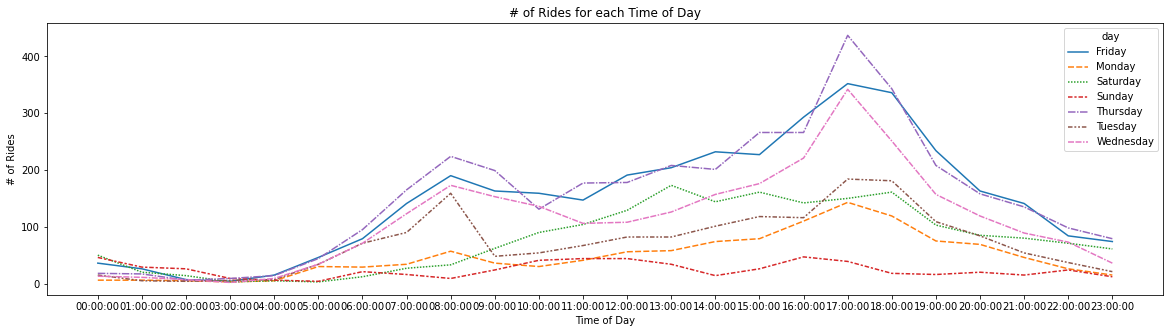

In [85]:
# Now you have everything you need to create and display a line graph that
# meets all the necessary criteria.
plot1_df_wide = plot1_df.pivot("Time of Day", "day", "Count")
plt.figure(figsize=(20,5)) 
sns.lineplot(data=plot1_df_wide).set(title="# of Rides for each Time of Day",ylabel="# of Rides")

Very interesting. Now for the second line plot, you will be visualizing the average duration of a ride that occurs during each hour of the day, for all 7 days. 

As a reminder, **your second line graph** should contain the following features:
1. The X-axis should be the same as last time
2. The Y-axis should be labelled "Average Duration".
3. There should be a title called "Average Duration of an Indego Bike Ride for each Time of Day"
4. There are 7 lines for each of the 7 days

In [86]:
# Second Plot:

# For this plot, create a dataframe that does not the trip_id column
plot2_df = new_trips[['duration','Day','Time of Day']].groupby(["Time of Day","Day"]).mean()
plot2_df.reset_index(inplace=True)
plot2_df = plot2_df.rename({"duration":"Average Duration"}, axis=1)
# plot1_df = plot1_df[["day", "Time of Day", "Count"]]
plot2_df["Time of Day"] = plot2_df["Time of Day"].astype(str)
plot2_df
# Now, alter this dataframe to have 3 columns, IN THIS ORDER:
# 'day', 'Time of Day', 'Average Duration'. Average Duration is the mean duration time
# for the particular hour of that day. 


# Now just plot the graph


,Time of Day,Day,Average Duration
0,00:00:00,Friday,22.472222
1,00:00:00,Monday,7.833333
2,00:00:00,Saturday,13.580000
3,00:00:00,Sunday,11.521739
4,00:00:00,Thursday,10.777778
...,...,...,...
162,23:00:00,Saturday,10.868852
163,23:00:00,Sunday,8.166667
164,23:00:00,Thursday,9.063291
165,23:00:00,Tuesday,11.904762


[Text(0, 0.5, 'Average Duration'),
 Text(0.5, 1.0, 'Average Duration of an Indego Bike Ride for each Time of Day')]

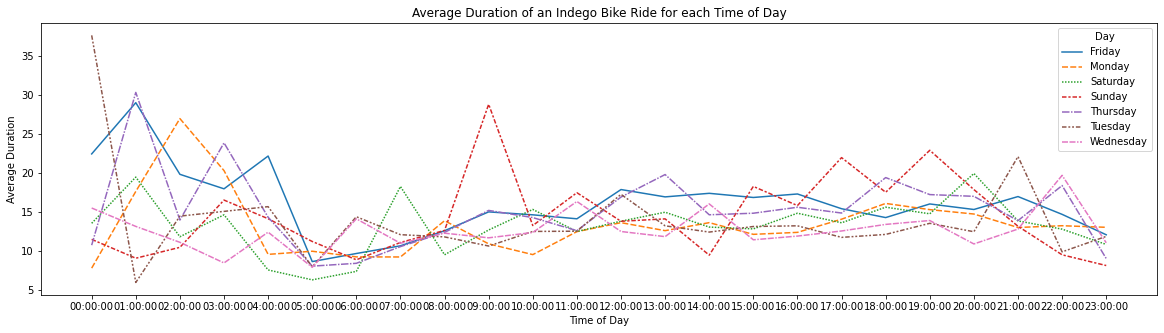

In [87]:
plot2_df_wide = plot2_df.pivot("Time of Day", "Day", "Average Duration")
plt.figure(figsize=(20,5)) 
sns.lineplot(data=plot2_df_wide).set(title="Average Duration of an Indego Bike Ride for each Time of Day",ylabel="Average Duration")


## Part 4: Working with Text Data [9 points]

Now, let's switch gears and try to text-based analysis. Textual data is complex, but can also be used to generate extremely interpretable results, making it both valuable and interesting. 

Throughout this section, we will attempt to answer the following question:

**According to the `reviews_df` dataframe, what do the reviews for some of the most popular restaurants in Philadelphia look like?**

###4.1 Tokenizing the text [2 points]

We are going to split the contents of the `reviews` column from `reviews_df` into a list of words. We will use the **nltk** library, which contains an extensive set of tools for text processing. Now, this homework would be interminably long if we went into all the details of nltk. Thus, we are only going to use the following components of the library:
- `nltk.word_tokenize()`: a function used to tokenize text
- `nltk.corpus.stopwords`: a list of commonly used words such as "a", "an","in" that are often ignored in text analysis

Note that for this question, we didn't have to clean the text data first as our original dataset was well-formatted. However, in practice, we would typically clean the text first using regular expressions (regex). Keep this in mind as you work on the project later on in the semester.

**TODO:** Perform the following tasks:
- Use **nltk.corpus.stopwords** to create a set containing the most common English stopwords.
- Implement the function **tokenized_content(content)**, which takes in a string and does the following:
1. Tokenize the text
2. Keep tokens that only contain alphabetic characters (i.e. tokens with no punctuation)
3. Convert each token to lowercase
4. Remove stopwords (commonly used words such as "a", "an", "in")


In [88]:
# We've imported the nltk library and created the stopwords set for you
import re
from string import punctuation

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [89]:
# TODO: tokenize and flatten 
# (create a tokenized_content function that performs the steps listed above)

def tokenized_content(content):
  content = nltk.word_tokenize(content)
  tokens = []
  for c in content:
    if c.isalpha():
      token = c.lower()
      if token and token not in stopwords:
        tokens.append(token)
  return tokens

In [90]:
tokenized_content("THIS TEXT WILL BE LOWERCASED. THIS WON'T: ßßß")

['text', 'lowercased', 'wo', 'ßßß']

 **TODO**: Now perform the following tasks: 
- We are interested in reviews for the **most reviewed** restaurant in `reviews_df`. Using Counter() to find this restaurant is recommended. Store the name of the restaurant in the `most_reviewed_restaurant` variable, and use it to create `restaurant_reviews_df`, a subset of `reviews_df` only containing instances from the restaurant in question
- From there, extract the `review` column of `reviews_df` as a list called `reviews`. 
- Apply your `tokenize_content()` function to each item in the list `reviews`. Call the resultant list `top_tokens_list`. 
- Flatten the list `top_tokens_list`, and call the resultant list `top_tokens`. The autograder will be examining the contents of this list. (Flatten using list comprehension)

For futher assistance, here is the documentation for Counter() objects: 

https://docs.python.org/2/library/collections.html#counter-objects

In [92]:
from collections import Counter
# TODO: find the most reviewed restaurant, use that to make restaurant_reviews_df,
#       extract the reviews, use your function to make the token list, and flatten it

most_reviewed_restaurant = list(Counter(reviews_df['restaurant']).items())[0]
for r in Counter(reviews_df['restaurant']).items():
  if r[1] > most_reviewed_restaurant[1]:
    most_reviewed_restaurant = r
most_reviewed_restaurant = most_reviewed_restaurant[0]
print(most_reviewed_restaurant)
restaurant_reviews_df = reviews_df[reviews_df['restaurant'] == most_reviewed_restaurant]
# restaurant_reviews_df
reviews = restaurant_reviews_df.review.tolist()
top_tokens_list = [tokenized_content(review) for review in reviews]
top_tokens = []
for ele in top_tokens_list:
  for item in ele:
    top_tokens.append(item)

Rose Restaurant


In [93]:
# 2 points
grader.grade(test_case_id = 'test_top_tokens', answer = top_tokens)

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.



### 4.2 Most Frequent Words [2 points]
**TODO**: Now, find the 10 most common words amongst the content of `top_tokens`. Return this as a list of `(word, count)` tuples, in descending order of `count`. Store this variable in `top_ten_words`

**Hint**: We again recommend using `Counter` in this question.

In [94]:
# TODO: From top_tokens, find the ten most frequent words
top_ten_words = Counter(top_tokens).most_common(10)

In [95]:
# 2 points
grader.grade(test_case_id = 'test_top_most_common', answer = top_ten_words)

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### 4.3 Word Clouds [5 points]

Before we move on from this dataset, let's visualize our results using a word cloud.

**TODO**: Create a word cloud containing all the words in the list `top_tokens` (created in part 4.1). [The WordCloud documentation](https://amueller.github.io/word_cloud/generated/wordcloud.WordCloud.html) contains instructions on how to do this. 

*Please make sure your wordcloud has a **lavender** background color.*

We will be going through your notebooks and **manually grading** your word cloud. This is worth 5 points. 

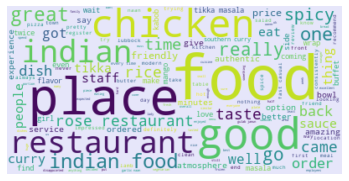

In [96]:
# TODO: generate your word cloud, making sure it meets the requirements above
import wordcloud
wordcloud = wordcloud.WordCloud(background_color="lavender")
wordcloud.generate(" ".join(top_tokens))
plt.axis("off")
plt.imshow(wordcloud, interpolation="bilinear")
plt.show()

# HW Submission

<br>
<center><img src = "https://i.imgflip.com/79knab.jpg" width= "500" align ="center"/></center>
<br>

Congratulations on finishing this homework! The good news is that similar to HW1, you basically know your score when you submit to Gradescope. 
However, this time, we will be manually grading your lineplots and wordclouds, so the autograder score is not final! Remember that we will also be checking for plagiarism, so please make sure to cite your sources (if any) by commenting the urls / links you looked at.

Before you submit on Gradescope (you must submit your notebook to receive credit):

1.   Please rerun your notebook on Colab by clicking "Restart and Run-All", and make sure there is nothing wrong with your notebook.
2.   **Double check that you have the correct PennID (all numbers) saved in the autograder**. 
3. Make sure you've run all the PennGrader cells and have received a score.
4. Go to the "File" tab at the top left, and click "Download .ipynb" + "Download .py". Please name the `.ipynb` and `.py` files **"homework2.ipynb"** and **"homework2.py"** respectively. Then, upload both the `.py` and `.ipynb` files to Gradescope. 

###Be sure to name your files correctly!!!

**Please let the course staff know ASAP if you have any issues submitting.**